<a href="https://colab.research.google.com/github/BosieAkUSD/visionnet-human-detection/blob/main/RO_ComputerVision_DefaultDataset_FinalProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import matplotlib.pyplot as plt

In [ ]:
#connect to Google Drive
from google.colab import drive
drive.mount('/content/drive')
!ls 'drive/MyDrive/Computer_Vision_Notebooks/human_detection_dataset'

Mounted at /content/drive
0  1


In [ ]:
cd 'drive/MyDrive/Computer_Vision_Notebooks/human_detection_dataset'

/content/drive/MyDrive/Computer_Vision_Notebooks/human_detection_dataset


Checking folder: /content/drive/MyDrive/Computer_Vision_Notebooks/human_detection_dataset/0
Number of image files in 0: 362
Checking folder: /content/drive/MyDrive/Computer_Vision_Notebooks/human_detection_dataset/1
Number of image files in 1: 559


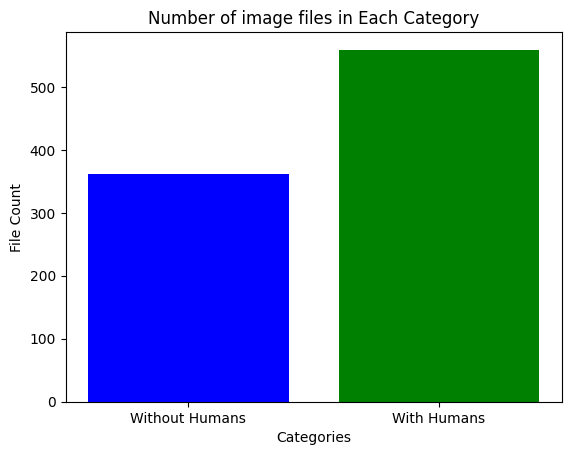

In [ ]:
# Plot number of images per category. [0] = no humans , [1] with human
# Base path
base_path = "/content/drive/MyDrive/Computer_Vision_Notebooks/human_detection_dataset"
directories = ["0", "1"]
# Custom labels for directories
labels = {
    "0": "Without Humans",
    "1": "With Humans"
}

# Count .jpg or png files
file_counts = {}
for folder in directories:
    folder_path = os.path.join(base_path, folder)
    print(f"Checking folder: {folder_path}")
    if os.path.exists(folder_path):
        jpg_count = len([f for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg'))])
        file_counts[folder] = jpg_count
        print(f"Number of image files in {folder}: {jpg_count}")
    else:
        print(f"Folder {folder_path} does not exist!")
        file_counts[folder] = 0

# Replace keys with custom labels for plotting
plot_labels = [labels[key] for key in file_counts.keys()]

# Plot the counts
plt.bar(plot_labels, file_counts.values(), color=['blue', 'green'])
plt.title("Number of image files in Each Category")
plt.xlabel("Categories")
plt.ylabel("File Count")
plt.show()


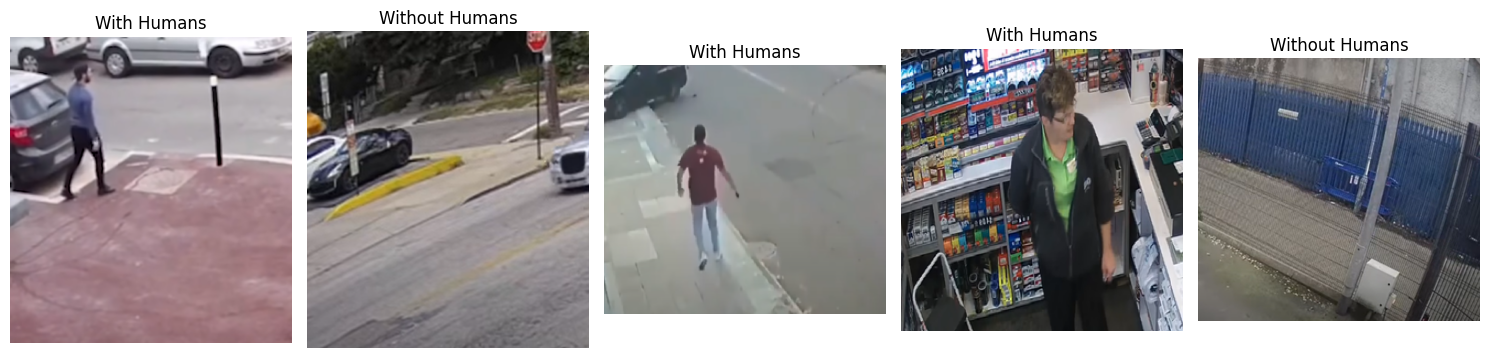

In [ ]:
import random
from matplotlib.image import imread
# Collect all image paths with their labels
image_paths = []
for label in directories:
    folder_path = os.path.join(base_path, label)
    images = [os.path.join(folder_path, img) for img in os.listdir(folder_path) if img.lower().endswith(('.png'))]
    image_paths.extend([(img_path, labels[label]) for img_path in images])

# Select 5 random images
random_images = random.sample(image_paths, 5)

# Plot the images with labels
plt.figure(figsize=(15, 10))
for i, (img_path, label) in enumerate(random_images, start=1):
    img = imread(img_path)
    plt.subplot(1, 5, i)
    plt.imshow(img)
    plt.title(label)
    plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
!pip install tensorflow-addons==0.20.0

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.utils import image_dataset_from_directory
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.python.keras.utils import tf_utils

In [ ]:
# Directory with dataset
data_dir = "/content/drive/MyDrive/Computer_Vision_Notebooks/human_detection_dataset"

# Load dataset
batch_size = 32
img_size = (224, 224)

# Split data into train, validation, and test sets
train_dataset = image_dataset_from_directory(
    data_dir,
    labels="inferred",
    label_mode="int",
    batch_size=batch_size,
    image_size=img_size,
    shuffle=True,
    validation_split=0.2,  # 20% for validation/test split
    subset="training",
    seed=123,
)

val_dataset = image_dataset_from_directory(
    data_dir,
    labels="inferred",
    label_mode="int",
    batch_size=batch_size,
    image_size=img_size,
    shuffle=True,
    validation_split=0.2,
    subset="validation",
    seed=123,
)

Found 921 files belonging to 2 classes.
Using 737 files for training.
Found 921 files belonging to 2 classes.
Using 184 files for validation.


In [ ]:
# Create a test dataset from the validation dataset
val_batches = tf.data.experimental.cardinality(val_dataset)
test_dataset = val_dataset.take(val_batches // 2)  # Half of validation for testing
val_dataset = val_dataset.skip(val_batches // 2)  # Remaining half for validation

In [ ]:
# Normalize pixel values
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y))
val_dataset = val_dataset.map(lambda x, y: (normalization_layer(x), y))
test_dataset = test_dataset.map(lambda x, y: (normalization_layer(x), y))

# Use prefetching to improve performance
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)


In [ ]:

# Build the VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model
base_model.trainable = False

# Add custom layers
x = Flatten()(base_model.output)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)  # Binary classification

# Create the model
model = Model(inputs=base_model.input, outputs=output)

loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss=loss,
    metrics=['accuracy']
)


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [ ]:
# Train the model
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=20
)


Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/nn.py:707: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


24/24 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step - accuracy: 0.5444 - loss: 0.7423 - val_accuracy: 0.6818 - val_loss: 0.6086
Epoch 2/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - accuracy: 0.6631 - loss: 0.6209 - val_accuracy: 0.6932 - val_loss: 0.6016
Epoch 3/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - accuracy: 0.7037 - loss: 0.5558 - val_accuracy: 0.7386 - val_loss: 0.5428
Epoch 4/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - accuracy: 0.7107 - loss: 0.5407 - val_accuracy: 0.7273 - val_loss: 0.4910
Epoch 5/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - accuracy: 0.7694 - loss: 0.4887 - val_accuracy: 0.7500 - val_loss: 0.4675
Epoch 6/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - accuracy: 0.7762 - loss: 0.4818 - val_accuracy: 0.8409 - val_loss: 0.4511
Epoch 7/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - accuracy: 0.7842 - loss: 0.4460 - val_accuracy: 0.8182 - val_loss: 0.3941
Epoch 8/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - accuracy: 0.8086 - loss: 0.4271 - val_accuracy: 0.7614 - val_loss: 0.4

In [ ]:
model.save('/content/drive/MyDrive/Computer_Vision_Notebooks/saved_VGG16_model.keras')

In [ ]:
from tensorflow.keras.models import load_model

# Load the saved model
model = load_model('/content/drive/MyDrive/Computer_Vision_Notebooks/saved_VGG16_model.keras')

# Display the model's architecture (optional)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       3,211,392 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 24,349,253 (92.89 MB)

 Trainable params: 3,211,521 (12.25 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

 Optimizer params: 6,423,044 (24.50 MB)

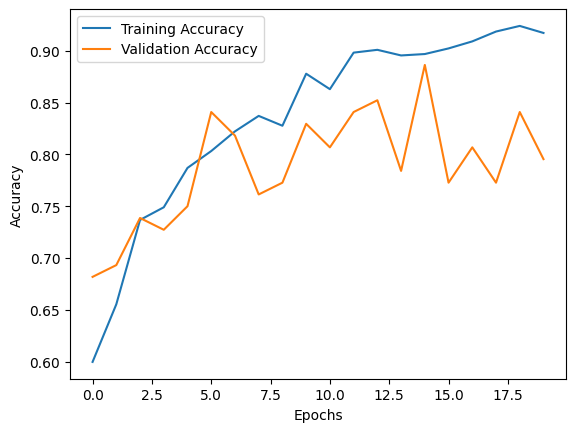

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.8203 - loss: 0.4335
Test Accuracy: 0.81
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step 


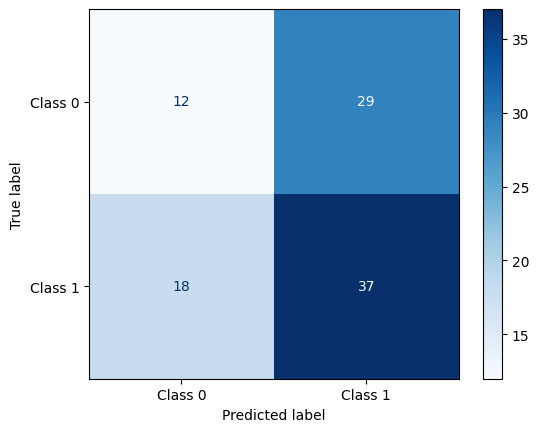

              precision    recall  f1-score   support

     Class 0       0.40      0.29      0.34        41
     Class 1       0.56      0.67      0.61        55

    accuracy                           0.51        96
   macro avg       0.48      0.48      0.47        96
weighted avg       0.49      0.51      0.49        96



In [ ]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test Accuracy: {test_accuracy:.2f}")

# Generate predictions and compute the confusion matrix
y_true = np.concatenate([y.numpy() for _, y in test_dataset], axis=0)
y_pred = (model.predict(test_dataset) > 0.5).astype(int).flatten()

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Class 0", "Class 1"])
disp.plot(cmap=plt.cm.Blues)
plt.show()

# Classification report
print(classification_report(y_true, y_pred, target_names=["Class 0", "Class 1"]))

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
Total Misclassified Images: 48


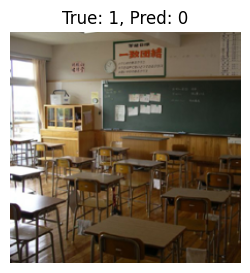

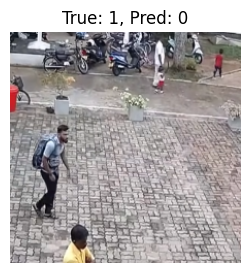

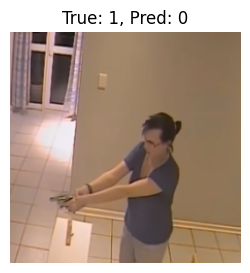

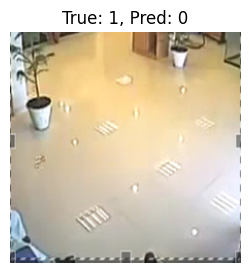

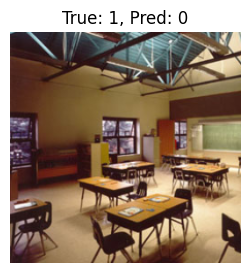

In [ ]:
import matplotlib.pyplot as plt

# Get true labels and predictions
y_true = np.concatenate([y.numpy() for _, y in test_dataset], axis=0)
y_pred = (model.predict(test_dataset) > 0.5).astype(int).flatten()

# Find misclassified indices
misclassified_indices = np.where(y_true != y_pred)[0]

# If there are misclassified images, display them
if len(misclassified_indices) > 0:
    print(f"Total Misclassified Images: {len(misclassified_indices)}")
    # Take up to 5 misclassified images
    for i, idx in enumerate(misclassified_indices[:5]):
        # Get the corresponding image and label
        for batch in test_dataset:
            images, labels = batch
            if idx < len(images):
                img = images[idx]
                true_label = y_true[idx]
                pred_label = y_pred[idx]
                break
            idx -= len(images)

        # Plot the image
        plt.figure(figsize=(3, 3))
        plt.imshow(img.numpy())
        plt.title(f"True: {true_label}, Pred: {pred_label}")
        plt.axis('off')
        plt.show()
else:
    print("No misclassified images found!")


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Total Misclassified Images: 50


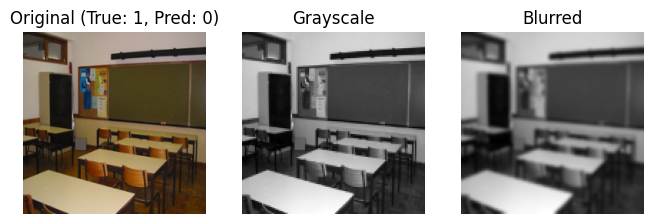

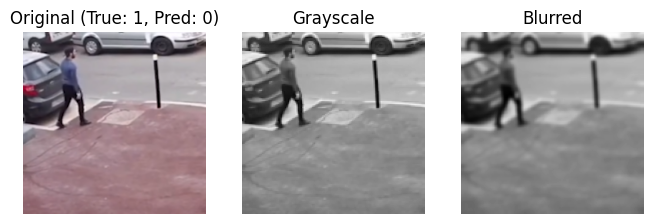

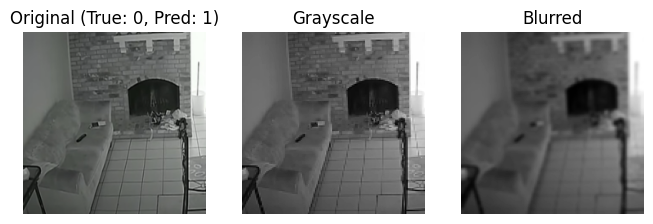

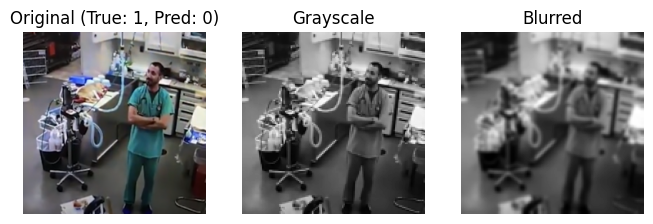

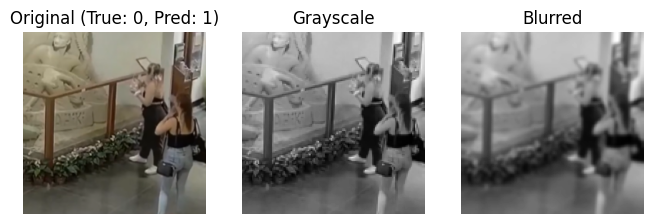

In [ ]:
import cv2
import matplotlib.pyplot as plt

# Get true labels and predictions
y_true = np.concatenate([y.numpy() for _, y in test_dataset], axis=0)
y_pred = (model.predict(test_dataset) > 0.5).astype(int).flatten()

# Find misclassified indices
misclassified_indices = np.where(y_true != y_pred)[0]

# If there are misclassified images, process and display them
if len(misclassified_indices) > 0:
    print(f"Total Misclassified Images: {len(misclassified_indices)}")

    for i, idx in enumerate(misclassified_indices[:5]):  # Show up to 5 misclassified images
        for batch in test_dataset:
            images, labels = batch
            if idx < len(images):
                img = images[idx].numpy()  # Convert tensor to NumPy array
                true_label = y_true[idx]
                pred_label = y_pred[idx]
                break
            idx -= len(images)

        # Convert image from RGB to BGR (OpenCV uses BGR format)
        img_bgr = cv2.cvtColor((img * 255).astype('uint8'), cv2.COLOR_RGB2BGR)

        # Example OpenCV operations:
        # 1. Resize the image
        resized_img = cv2.resize(img_bgr, (128, 128))

        # 2. Convert to grayscale
        gray_img = cv2.cvtColor(resized_img, cv2.COLOR_BGR2GRAY)

        # 3. Apply Gaussian blur
        blurred_img = cv2.GaussianBlur(gray_img, (5, 5), 0)

        # Display original and processed images
        plt.figure(figsize=(8, 8))
        plt.subplot(1, 3, 1)
        plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))  # Convert back to RGB for display
        plt.title(f"Original (True: {true_label}, Pred: {pred_label})")
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.imshow(gray_img, cmap='gray')
        plt.title("Grayscale")
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.imshow(blurred_img, cmap='gray')
        plt.title("Blurred")
        plt.axis('off')

        plt.show()
else:
    print("No misclassified images found!")


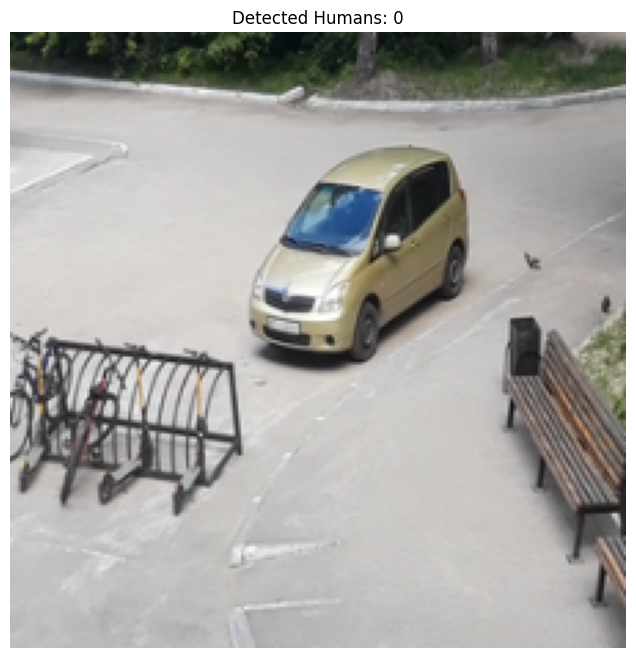

Real Label for Misclassified Image: 1


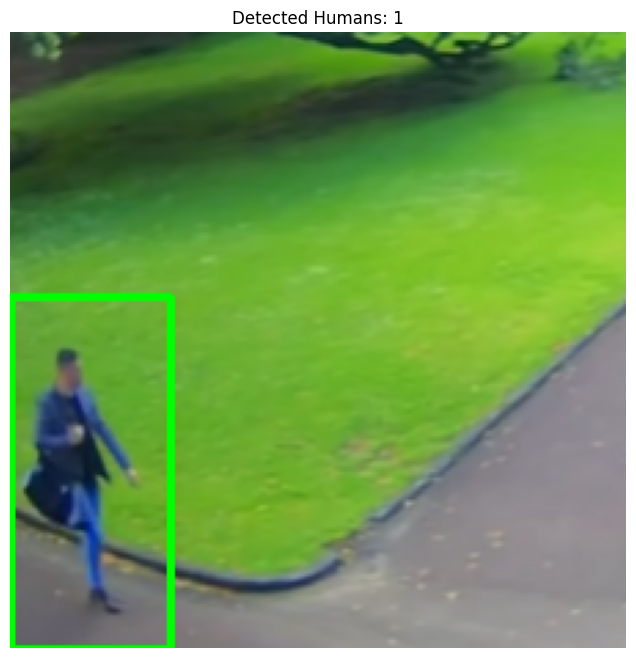

In [ ]:

# Initialize the HOG descriptor/person detector
hog = cv2.HOGDescriptor()
hog.setSVMDetector(cv2.HOGDescriptor_getDefaultPeopleDetector())

def detect_and_display(image):
    # Convert image to BGR (if needed) for OpenCV operations
    image_bgr = cv2.cvtColor((image * 255).astype('uint8'), cv2.COLOR_RGB2BGR)

    # Detect humans in the image
    (rects, weights) = hog.detectMultiScale(image_bgr,
                                            winStride=(4, 4),
                                            padding=(8, 8),
                                            scale=1.05)

    # Draw bounding boxes for detected humans
    for (x, y, w, h) in rects:
        cv2.rectangle(image_bgr, (x, y), (x + w, y + h), (0, 255, 0), 2)

    # Convert the image back to RGB for displaying with Matplotlib
    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

    # Display the image
    plt.figure(figsize=(8, 8))
    plt.imshow(image_rgb)
    plt.title(f"Detected Humans: {len(rects)}")
    plt.axis('off')
    plt.show()

# Example: Test the function on a misclassified image
for i, idx in enumerate(misclassified_indices[:1]):  # Using one image for demonstration
    for batch in test_dataset:
        images, labels = batch
        if idx < len(images):
            img = images[idx].numpy()  # Convert tensor to NumPy array
            detect_and_display(img)  # Detect and display humans
            break
        idx -= len(images)

# Test the function and print real labels for misclassified images
for i, idx in enumerate(misclassified_indices[:1]):  # Using one image for demonstration
    for batch_index, batch in enumerate(test_dataset):
        images, labels = batch
        if idx < len(images):
            img = images[idx].numpy()  # Convert tensor to NumPy array

            # Retrieve the real label
            real_label = labels[idx].numpy()
            print(f"Real Label for Misclassified Image: {real_label}")

            # Detect and display humans
            detect_and_display(img)
            break
        idx -= len(images)

# VGG16 with updated dataset after misclasified images were found


In [ ]:
!ls "/content/drive/MyDrive/Computer_Vision_Notebooks/human_detection_dataset_updated"

with_human  without_human


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.utils import image_dataset_from_directory
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.python.keras.utils import tf_utils

Checking folder: /content/drive/MyDrive/Computer_Vision_Notebooks/human_detection_dataset_updated/0
Number of image files in 0: 363
Checking folder: /content/drive/MyDrive/Computer_Vision_Notebooks/human_detection_dataset_updated/1
Number of image files in 1: 558


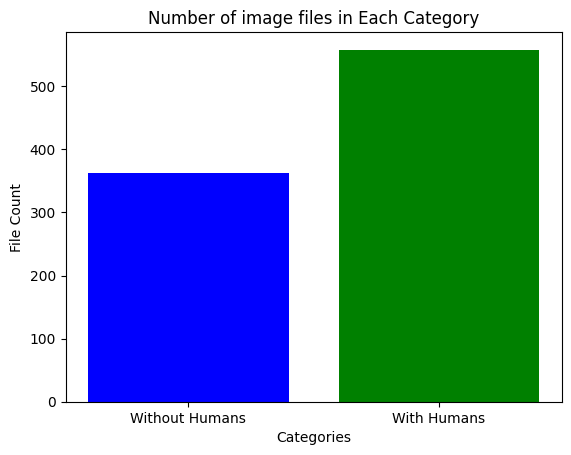

In [ ]:
# Plot number of images per category. [0] = no humans , [1] with human
# Base path
base_path = "/content/drive/MyDrive/Computer_Vision_Notebooks/human_detection_dataset_updated"
directories = ["0", "1"]
# Custom labels for directories
labels = {
    "0": "Without Humans",
    "1": "With Humans"
}

# Count .jpg or png files
file_counts = {}
for folder in directories:
    folder_path = os.path.join(base_path, folder)
    print(f"Checking folder: {folder_path}")
    if os.path.exists(folder_path):
        jpg_count = len([f for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg'))])
        file_counts[folder] = jpg_count
        print(f"Number of image files in {folder}: {jpg_count}")
    else:
        print(f"Folder {folder_path} does not exist!")
        file_counts[folder] = 0

# Replace keys with custom labels for plotting
plot_labels = [labels[key] for key in file_counts.keys()]

# Plot the counts
plt.bar(plot_labels, file_counts.values(), color=['blue', 'green'])
plt.title("Number of image files in Each Category")
plt.xlabel("Categories")
plt.ylabel("File Count")
plt.show()

In [ ]:
# Directory with dataset
data_dir = "/content/drive/MyDrive/Computer_Vision_Notebooks/human_detection_dataset_updated"

# Load dataset
batch_size = 32
img_size = (224, 224)

# Split data into train, validation, and test sets
train_dataset = image_dataset_from_directory(
    data_dir,
    labels="inferred",
    label_mode="int",
    batch_size=batch_size,
    image_size=img_size,
    shuffle=True,
    validation_split=0.2,  # 20% for validation/test split
    subset="training",
    seed=123,
)

val_dataset = image_dataset_from_directory(
    data_dir,
    labels="inferred",
    label_mode="int",
    batch_size=batch_size,
    image_size=img_size,
    shuffle=True,
    validation_split=0.2,
    subset="validation",
    seed=123,
)

Found 921 files belonging to 2 classes.
Using 737 files for training.
Found 921 files belonging to 2 classes.
Using 184 files for validation.
